6


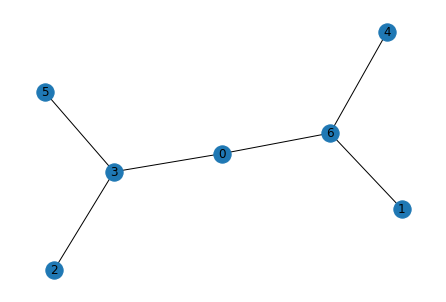

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from query_graphs.query_graphs import QueryGraphs

#query_graph = QueryGraphs().get_graph_7(9)
query_graph = QueryGraphs().get_graph_8(7)
#query_graph = nx.path_graph(10)

n_joins = len(query_graph.edges) - len(nx.cycle_basis(query_graph))
max_number_of_levels = n_joins
print(max_number_of_levels)
levels = range(max_number_of_levels)

relations = {}
for node in query_graph.nodes(data=True):
    relations[node[0]] = node[1]

selectivities = dict()
for edge in query_graph.edges(data=True):
    selectivities[(edge[0], edge[1])] = edge[2]
    
nx.draw(query_graph, with_labels=True)

In [2]:
import matplotlib.pyplot as plt
from itertools import combinations

def get_connected_subgraphs_dfs(graph, node, n):
    connected_subgraphs = set()
    
    # Function to perform DFS to find connected subgraphs of size n
    def dfs(start_node, path):
        
        if len(path) == n + 1:
            connected_subgraphs.add(tuple(path))
            return
        
        for r in range(1, n - len(path) + 2):
            for neighbors_combination in combinations(graph.neighbors(start_node), r):
                for neighbor in neighbors_combination:
                    if neighbor not in path:
                        dfs(neighbor, path.union(set(neighbors_combination)))
    
    for r in range(1, n + 1):
        for neighbors_combination in combinations(graph.neighbors(node), r):
            for neighbor in neighbors_combination:
                dfs(neighbor, set(list(neighbors_combination) + [node]))
    
    return connected_subgraphs

In [3]:
from classical_algorithms.weights_costs import basic_cost, join_tree_cardinality


class Variable:
    
    def __init__(self, relations, selectivities, new_subgraph, subgraph, rel1, rel2, level, base_labeling):
        self.query_graph = query_graph
        self.subgraph = subgraph
        self.level = level
        self.local_cost = 1
        self.new_subgraph = new_subgraph
        
        tables = list(new_subgraph)
        join_tree = [tables[0], tables[1]]
        for rel in tables[2:]:
            join_tree = [rel, join_tree]

        self.local_cost = join_tree_cardinality(join_tree, relations, selectivities)
        
        self.labeling = base_labeling + [(rel1, rel2, level)]
        self.rel1 = rel1
        self.rel2 = rel2
        
    def get_labeling(self):
        return self.labeling
    
    def get_local_cost(self):
        return self.local_cost
    
    def __str__(self) -> str:
        return f'Variable({self.rel1}, {self.rel2}, {self.level}) with labelings {self.labeling} and local cost {self.local_cost}'

In [4]:
variables = {}
#all_connected_subgraphs = set()

for level in levels:
    for edge in query_graph.edges(data=True):
        
        if level == 0:
            subgraph = frozenset([edge[0], edge[1]])
            variables[subgraph] = [Variable(relations, selectivities, subgraph, subgraph, edge[0], edge[1], level, [])]
        else:
            join1 = edge[0]
            join2 = edge[1]
            
            query_graph_copy = query_graph.copy()
            edge_to_remove = (join1, join2)
            query_graph_copy.remove_edge(*edge_to_remove)
            
            connected_subgraphs = get_connected_subgraphs_dfs(query_graph_copy, join1, level)
            connected_subgraphs = connected_subgraphs.union(get_connected_subgraphs_dfs(query_graph_copy, join2, level))
            
            #print("Number of subgraphs: ", len(connected_subgraphs))
            
            #print("Join: ", edge)
            #print("Level: ", level)
            #print(connected_subgraphs)
            #all_connected_subgraphs = all_connected_subgraphs.union(connected_subgraphs)
            
            for subgraph in connected_subgraphs:
                new_subgraph = frozenset(subgraph + (join1, join2))
                subgraph = frozenset(subgraph)
                
                #if new_subgraph not in variables:
                #    variables[new_subgraph] = []
                
                new_variables = {}
                 
                for var in variables[subgraph]:
                    #print(var)
                    
                    if new_subgraph not in new_variables:
                        new_variables[new_subgraph] = []
                    
                    new_variables[new_subgraph].append(Variable(relations, selectivities, new_subgraph, subgraph, join1, join2, level, var.get_labeling()))
                
                for new_s in new_variables:
                    if new_s in variables:
                        variables[new_s].extend(new_variables[new_s])
                    else:
                        variables[new_s] = new_variables[new_s]

In [5]:
import dimod

def variables_to_dict(variables):
    variables_dict = {}
    for v in variables:
        for var in variables[v]:
            labeling = var.get_labeling()
            variables_dict[tuple(labeling)] = var.get_local_cost()
    return variables_dict


var_dict = variables_to_dict(variables)

In [6]:
# At every level we perform exactly one join
hubo = dimod.BinaryPolynomial(var_dict, dimod.Vartype.BINARY)
hubo_total_cost = dimod.BinaryPolynomial(var_dict, dimod.Vartype.BINARY)
hubo.normalize()
hubo_variables = hubo.variables
print("Number of variables: ", len(hubo_variables))
var_dict, off = hubo.to_hubo()
#var_dict = {}

variables_by_levels = {}
for level in levels:
    variables_by_levels[level] = []
    for v in hubo_variables:
        if v[2] == level:
            variables_by_levels[level].append(v)
            
#print(variables_by_levels)

for l in variables_by_levels:
    vars = variables_by_levels[l]
    bqm = dimod.generators.combinations(vars, 1, strength = 5)
    for bvar in bqm.linear:
        if (bvar,) in var_dict:
            var_dict[(bvar,)] = bqm.linear[bvar] + var_dict[(bvar,)]
        else:
            var_dict[(bvar,)] = bqm.linear[bvar]
    for bvar in bqm.quadratic:
        if bvar in var_dict:
            var_dict[bvar] = bqm.quadratic[bvar] + var_dict[bvar]
        else:
            var_dict[bvar] = bqm.quadratic[bvar]           


Number of variables:  32


In [7]:
# (x - a - b - c)^2 = a^2 + 2 a b + 2 a c - 2 a x + b^2 + 2 b c - 2 b x + c^2 - 2 c x + x^2
def combinations_with_variable(x, vars, scaler = 1):
    result = {}
    result[(x,)] = scaler
    for v in vars:
        result[(v,)] = scaler
        result[(x, v)] = -2 * scaler
    
    for comb in combinations(vars, 2):
        result[comb] = 2 * scaler
    
    return result

In [8]:
import numpy as np

def table_number_constraint(tables, table_id, scaler = 1):
    # (1 + 2*x_2 + ... + max_number_of_levels * x_n - sum over table vars)^2
    
    integer_vars = []
    N = max_number_of_levels
    M = int(np.floor(np.log2(N)))
    
    # x_0 = 1 fixed
    for i in range(1, M + 1):
        if i == M:
            integer_vars.append((f'table_{table_id}_{i}', (N + 1 - 2**M)))
        integer_vars.append((f'table_{table_id}_{i}', 2**i))
        
    result = {}
    
    for int_var in integer_vars:
        result[(int_var[0],)] = scaler * (int_var[1]**2 + 2 * int_var[1])
    
    for table in tables:
        result[(table,)] = -scaler
    
    for x, y in combinations(integer_vars + tables, 2):
        if x in integer_vars and y in integer_vars:
            result[(x[0], y[0])] = 2 * scaler * x[1] * y[1]
        elif x in integer_vars and y in tables:
            result[(x[0], y)] = -2 * scaler * x[1]
        elif x in tables and y in integer_vars:
            result[(x, y[0])] = -2 * scaler * y[1]
        else:
            result[(x, y)] = 2 * scaler
    
    return result

In [9]:
if True:
    # Encode (1 - labelings for variables[frozenset({0, 1, 2, 3, 4})])^2
    # (1 - x - y - z)^2 = x^2 + 2 x y + 2 x z - 2 x + y^2 + 2 y z - 2 y + z^2 - 2 z + 1
    # = -x - y - z + 2 x y + 2 x z + 2 y z + 1    
    offset = 1
    scaler = 2
    labelings_for_full_join = [var.get_labeling() for var in variables[frozenset(query_graph.nodes)]]
    print("Labelings for full join: ", len(labelings_for_full_join))
    for labeling in labelings_for_full_join:
        
        if tuple(labeling) in var_dict:
            var_dict[tuple(labeling)] = var_dict[tuple(labeling)] - 1*scaler
        else:
            var_dict[tuple(labeling)] = -1*scaler
            
    for comb in combinations(labelings_for_full_join, 2):
        prod = tuple(comb[0] + comb[1])
        if prod in var_dict:
            var_dict[prod] = var_dict[prod] + 2*scaler
        else:
            var_dict[prod] = 2*scaler
            
if False:
    # Constraint 1
    # select exactly n_joins many different joins
    variables_by_joins = {}
    for var in hubo_variables:
        join = (var[0], var[1])
        if join in variables_by_joins:
            variables_by_joins[join].append(var)
        else:
            variables_by_joins[join] = [var]
            
    #print("Joins: ", len(variables_by_joins))
    
    aux_vars = []
    for x, vars in variables_by_joins.items():
        aux_var = 'aux_' + str(x)
        aux_vars.append(aux_var)
        combs = combinations_with_variable(aux_var, vars, scaler=3)
        for comb in combs:
            if comb in var_dict:
                var_dict[comb] = var_dict[comb] + combs[comb]
            else:
                var_dict[comb] = combs[comb]
                
    # Select exactly n_joins many aux_vars to be true
    
    bqm = dimod.generators.combinations(aux_vars, n_joins, strength=3)
    
    for bvar in bqm.linear:
        if (bvar,) in var_dict:
            var_dict[(bvar,)] = bqm.linear[bvar] + var_dict[(bvar,)]
        else:
            var_dict[(bvar,)] = bqm.linear[bvar]
    
    for bvar in bqm.quadratic:
        if bvar in var_dict:
            var_dict[bvar] = bqm.quadratic[bvar] + var_dict[bvar]
        else:
            var_dict[bvar] = bqm.quadratic[bvar]
    
    # Constraint 2
    # level + 1 should be connecte to level so that if (x, y, l) and (x', y', l + 1) and x != x' and y != y' then (x, y, l) and (x', y', l + 1) should be penalized
    scaler = 5
    
    for level in levels:
        if level == 0:
            continue
        
        join_vars = variables_by_levels[level]
        prev_join_vars = variables_by_levels[level - 1]
        
        for var1 in join_vars:
            for var2 in prev_join_vars:
                if var1[0] != var2[0] and var1[1] != var2[1]:
                    # Penalize if two joins are not connected
                    if (var1, var2) in var_dict:
                        var_dict[(var1, var2)] = var_dict[(var1, var2)] + scaler
                    else:
                        var_dict[(var1, var2)] = scaler
                        
    # Constraint 3
    # Every table has to appear at least once (max as many times as the number of joins)
    
    variables_by_tables = {}
    for var in hubo_variables:
        for table in var[0:2]:
            if table in variables_by_tables:
                variables_by_tables[table].append(var)
            else:
                variables_by_tables[table] = [var]
    
    print(variables_by_tables)
    
    for table_id, tables in variables_by_tables.items():
        combs = table_number_constraint(tables, table_id, scaler=1)
        for comb in combs:
            if comb in var_dict:
                var_dict[comb] = var_dict[comb] + combs[comb]
            else:
                var_dict[comb] = combs[comb]
    

Labelings for full join:  120


In [10]:
hubo = dimod.BinaryPolynomial(var_dict, dimod.Vartype.BINARY)
print("Number of variables: ", len(hubo.variables))
bqm = dimod.make_quadratic(var_dict, strength=1, vartype=dimod.Vartype.BINARY)

Number of variables:  32


In [11]:
from dwave.samplers import SteepestDescentSampler, SimulatedAnnealingSampler, TabuSampler

print("Number of variables: ", len(bqm.linear))
#print(hubo)
#hubo.normalize()
#solver = dimod.ExactPolySolver()

result = TabuSampler().sample(bqm, num_reads=7000)
#result = SteepestDescentSampler().sample(bqm, initial_states=samples)
#result = solver.sample_poly(hubo)
#result = solver.sample(bqm)
print(result.first.energy)
for res in result.first.sample:
    if result.first.sample[res] == 1 and "*" not in res and "_" not in res:
        print(res)

Number of variables:  1849


In [ ]:
#for s in result.first.sample:
#    if result.first.sample[s] == 1 and "*" not in s:
#        print(s)

In [ ]:
test_point = result.first.sample
print(hubo_total_cost.energy(test_point))

10.711245835601002


In [ ]:
import numpy as np

for v, value in hubo_total_cost.to_hubo()[0].items():
    if np.all([v1 in [(0, 3, 1), (0, 4, 3), (1, 3, 0), (2, 3, 2)] for v1 in v]):
        print(v, value)

In [ ]:
print(len(hubo_total_cost.variables))

32
